In [1]:
%load_ext autoreload
%autoreload 2
import sys
import torch
import math
import numpy as np
import pandas as pd
from torch import nn
sys.path.append('..')
from pathlib import Path
from typing import Union
from omegaconf import OmegaConf
from torch.utils import data
import matplotlib.pyplot as plt
from erank.data import get_metadataset_class
from erank.data.miniimagenetdataset import MiniImagenetDataset
from ml_utilities.data_utils import show_images, Normalizer
gpu_id = 0

/home/max/anaconda3/envs/erank/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Specify dataset directory etc.

In [2]:
data_dir = '/home/max/phd/data'
dataset_name = 'miniImagenet'
splits_num_classes = {'train': 64, 'val': 16, 'test': 20}

## Check file directory

In [3]:
# check folders
dataset_dir = Path(data_dir) / dataset_name
toplevel_folders_disk = [d.stem for d in dataset_dir.iterdir() if d.is_dir()]
set(splits_num_classes.keys()).issubset(set(toplevel_folders_disk))

True

In [4]:
# check files
pd.read_csv(dataset_dir/'train.csv')

,filename,label
0,n0153282900000005.jpg,n01532829
1,n0153282900000006.jpg,n01532829
2,n0153282900000007.jpg,n01532829
3,n0153282900000010.jpg,n01532829
4,n0153282900000014.jpg,n01532829
...,...,...
38395,n1313361300001288.jpg,n13133613
38396,n1313361300001290.jpg,n13133613
38397,n1313361300001296.jpg,n13133613
38398,n1313361300001297.jpg,n13133613


## Dataset initialization + data loading

In [5]:
mids = MiniImagenetDataset(data_root_path=data_dir,
                           n_way_classification=5,
                           support_size=5,
                           query_size=10,
                           num_tasks=5,
                           split='train',
                           seed=0)


Loading MiniImagenet classes: 100%|██████████| 64/64 [00:20<00:00,  3.09it/s]


In [6]:
# number of classes
classes = list(mids._data.keys())
len(classes), classes[:10]

(64,
 ['n01532829',
  'n01558993',
  'n01704323',
  'n01749939',
  'n01770081',
  'n01843383',
  'n01910747',
  'n02074367',
  'n02089867',
  'n02091831'])

In [7]:
# shape of data stored in dataset
imgs = mids._data[classes[0]]
imgs.shape

(600, 3, 84, 84)

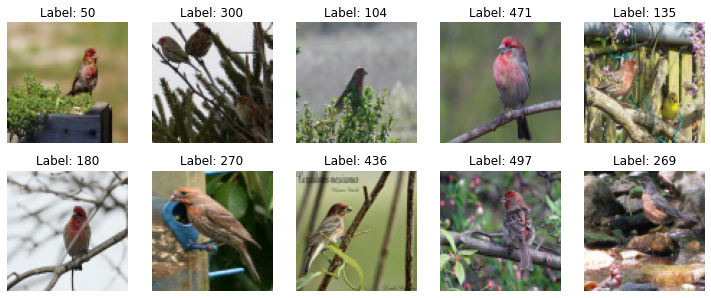

In [8]:
show_images(imgs, num_images=10, n_cols=5)

## Task generation

In [9]:
for t in mids.pregen_tasks:
    print(t.name)

n01704323#n02795169#n03207743#n03347037#n04296562
n02074367#n02457408#n04258138#n04389033#n07697537
n02089867#n02108089#n02457408#n04243546#n04389033
n02089867#n02823428#n03017168#n03337140#n03908618
n02108915#n02165456#n02966193#n03017168#n04435653


In [16]:
# different seed -> must sample other tasks, same seed -> same tasks OK
mids1 = MiniImagenetDataset(data_root_path=data_dir,
                       n_way_classification=5,
                       support_size=5,
                       query_size=10,
                       num_tasks=5,
                       split='train',
                       seed=1)

for t in mids1.pregen_tasks:
    print(t.name)

Loading MiniImagenet classes: 100%|██████████| 64/64 [00:21<00:00,  2.98it/s]
n01558993#n01843383#n03400231#n03888605#n06794110
n01704323#n02457408#n02966193#n04509417#n07697537
n01770081#n02101006#n04243546#n04515003#n07584110
n01843383#n02105505#n02113712#n03476684#n03676483
n03207743#n03347037#n03998194#n04612504#n13054560


In [17]:
mids.get_tasks(num_tasks=1)[0].name, mids1.get_tasks(num_tasks=1)[0].name

('n01704323#n02795169#n03207743#n03347037#n04296562',
 'n01558993#n01843383#n03400231#n03888605#n06794110')

## Task support and query set sampling

In [6]:
mids = MiniImagenetDataset(data_root_path=data_dir,
                       n_way_classification=5,
                       support_size=5,
                       query_size=10,
                       num_tasks=5,
                       split='train',
                       regenerate_task_support_set=True,
                       regenerate_task_query_set=False,
                       seed=0)
for task in mids.get_tasks(num_tasks=5):
    print(task.name, len(task.support_set))

Loading MiniImagenet classes: 100%|██████████| 64/64 [00:19<00:00,  3.23it/s]
n01704323#n02795169#n03207743#n03347037#n04296562 2
n02074367#n02457408#n04258138#n04389033#n07697537 2
n02089867#n02108089#n02457408#n04243546#n04389033 2
n02089867#n02823428#n03017168#n03337140#n03908618 2
n02108915#n02165456#n02966193#n03017168#n04435653 2


In [7]:
task = mids.get_tasks(num_tasks=1)[0]
task.name, len(task.support_set)

('n01704323#n02795169#n03207743#n03347037#n04296562', 2)

In [8]:
x_, y_ = task.support_set
x_.shape, y_.shape

(torch.Size([25, 3, 84, 84]), torch.Size([25]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

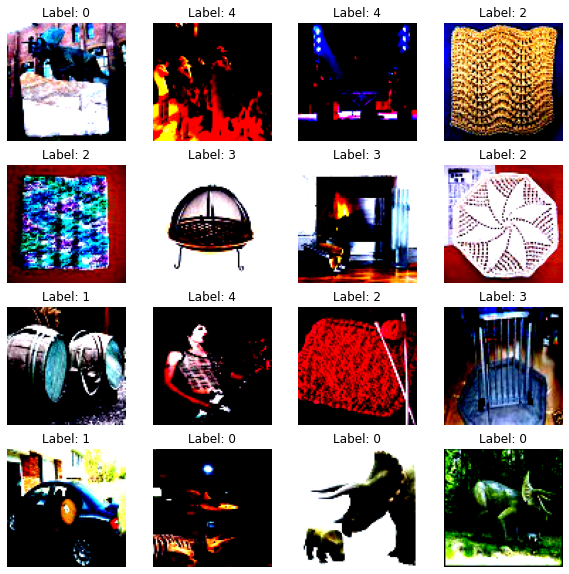

In [9]:
show_images((x_, y_), num_images=16)

In [10]:
task._support_idxes[task.task_classes[0]], task._query_idxes[task.task_classes[0]]

(array([363,  50, 179, 451,  78]),
 array([380, 487, 556, 128, 291, 424, 536, 240, 474,  70]))

In [11]:
for t_cls in task.task_classes:
    supp_idxes = task._support_idxes[t_cls]
    query_idxes = task._query_idxes[t_cls]
    intersect = np.intersect1d(supp_idxes, query_idxes)
    print(intersect)
    # assert len(intersect) == 0

[]
[]
[]
[]
[]


## Dataset Normalization

In [12]:
mids = MiniImagenetDataset(data_root_path=data_dir,
                       n_way_classification=5,
                       support_size=5,
                       query_size=10,
                       num_tasks=5,
                       split='train',
                       regenerate_task_support_set=True,
                       regenerate_task_query_set=False,
                       seed=0, 
                       normalizer=None)
normalizer_values = mids.compute_normalizer()
normalizer_values

Loading MiniImagenet classes:  20%|██        | 13/64 [00:04<00:17,  2.98it/s]


KeyboardInterrupt: 

In [11]:
tasks = mids.sample_tasks(num_tasks=1)

In [12]:
task = tasks[0]
support_x = task.support_set[0]
task.name, support_x.shape, task.support_set[1].shape

('n02101006#n03047690#n03888605#n03908618#n04067472',
 torch.Size([25, 3, 84, 84]),
 torch.Size([25]))

In [28]:
normalizer = Normalizer(scaler_values=normalizer_values)
normalizer(support_x).shape

torch.Size([25, 3, 84, 84])

In [35]:
s = torch.randn(size=(5,3,28,28))
normalizer(s).shape

torch.Size([5, 3, 28, 28])

In [13]:
mids2 = MiniImagenetDataset(data_root_path=data_dir,
                       n_way_classification=5,
                       support_size=5,
                       query_size=10,
                       num_tasks=5,
                       split='train',
                       regenerate_task_support_set=True,
                       regenerate_task_query_set=False,
                       seed=0)
tasks = mids2.sample_tasks(num_tasks=100)

Loading MiniImagenet classes: 100%|██████████| 64/64 [00:20<00:00,  3.16it/s]


In [14]:
mids2.normalizer

Normalizer(mean=[120.1979412172855, 114.82953431329128, 102.99532529569989], std=[55.8573964877539, 54.94042821584164, 55.151333856338944])

In [15]:
# calculate mean and std of task support sets
# should have mean 0 and std 1
mean = 0. 
std = 0.
num_samples = 0
for task in tasks:
    support_x = task.support_set[0]
    data_ = support_x.view(len(support_x), 1, -1)
    mean += data_.mean(dim=2).sum(dim=0)
    std += data_.std(dim=2).sum(dim=0)
    num_samples += len(support_x)
mean /= num_samples
std /= num_samples
mean, std

(tensor([-0.0151]), tensor([1.0528]))

## Use Dataloader for task loading

In [3]:
miniimagenet_cfg = f"""
data_root_path: {data_dir}
n_way_classification: 5
support_size: 5
query_size: 10
# dataset_layout: metadataset
split: train
num_tasks: 10
regenerate_task_support_set: True
regenerate_task_query_set: True
seed: 0
"""
miniimagenet_cfg = OmegaConf.create(miniimagenet_cfg)
miniimagenet_class = get_metadataset_class('mini-imagenet')
miniimagenet_dataset = miniimagenet_class(**miniimagenet_cfg)

Loading MiniImagenet classes: 100%|██████████| 64/64 [00:25<00:00,  2.55it/s]


In [4]:
dataloader = data.DataLoader(miniimagenet_dataset, batch_size=None, num_workers=4, persistent_workers=True)
episode_iter = iter(dataloader)

In [5]:
for i in range(5):
    task = next(episode_iter)
    print(task.name)

n02089867#n02108089#n02457408#n04243546#n04389033
n01843383#n02105505#n02113712#n03476684#n03676483
n01749939#n01843383#n02823428#n03998194#n04243546
n02747177#n03400231#n03476684#n04067472#n07697537
n01843383#n02108915#n02457408#n02606052#n02966193


In [6]:
for i in range(3):
    task.support_set
    for class_name, idxes in task._support_idxes.items():
        print('{cn:40s}:{idxes}'.format(cn=class_name, idxes=idxes))
    print('--')

n01843383                               :[323 112 457 110 527]
n02108915                               :[336 163 249 497 457]
n02457408                               :[487  30 216 124 296]
n02606052                               :[ 15 356 526  52 152]
n02966193                               :[431 411 560 224 554]
--
n01843383                               :[276 343 239 272 304]
n02108915                               :[269   7 468 402 359]
n02457408                               :[409 551 495  84 469]
n02606052                               :[240 139 232 386 368]
n02966193                               :[311 560 375 405  32]
--
n01843383                               :[293 323 336 421 504]
n02108915                               :[236 195   9 595 522]
n02457408                               :[335 519 435 324 154]
n02606052                               :[385  19 549 582 345]
n02966193                               :[ 15 197 382  70  43]
--


In [7]:
# Do it again to check reproducibility
miniimagenet_cfg = f"""
data_root_path: {data_dir}
n_way_classification: 5
support_size: 5
query_size: 10
# dataset_layout: metadataset
split: train
num_tasks: 10
regenerate_task_support_set: True
regenerate_task_query_set: True
seed: 0
"""
miniimagenet_cfg = OmegaConf.create(miniimagenet_cfg)
miniimagenet_class = get_metadataset_class('mini-imagenet')
miniimagenet_dataset = miniimagenet_class(**miniimagenet_cfg)

dataloader = data.DataLoader(miniimagenet_dataset, batch_size=None, num_workers=4, persistent_workers=True)
episode_iter = iter(dataloader)
print('')
for i in range(5):
    task = next(episode_iter)
    print(task.name)
print('')
for i in range(3):
    task.support_set
    for class_name, idxes in task._support_idxes.items():
        print('{cn:40s}:{idxes}'.format(cn=class_name, idxes=idxes))
    print('--')

Loading MiniImagenet classes: 100%|██████████| 64/64 [00:22<00:00,  2.83it/s]

n02089867#n02108089#n02457408#n04243546#n04389033
n01843383#n02105505#n02113712#n03476684#n03676483
n01749939#n01843383#n02823428#n03998194#n04243546
n02747177#n03400231#n03476684#n04067472#n07697537
n01843383#n02108915#n02457408#n02606052#n02966193

n01843383                               :[323 112 457 110 527]
n02108915                               :[336 163 249 497 457]
n02457408                               :[487  30 216 124 296]
n02606052                               :[ 15 356 526  52 152]
n02966193                               :[431 411 560 224 554]
--
n01843383                               :[276 343 239 272 304]
n02108915                               :[269   7 468 402 359]
n02457408                               :[409 551 495  84 469]
n02606052                               :[240 139 232 386 368]
n02966193                               :[311 560 375 405  32]
--
n01843383                         